In [72]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from nlpretext.textloader import TextLoader
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (normalize_whitespace, remove_punct, 
remove_eol_characters,remove_stopwords, lower_text)
from nlpretext.social.preprocess import remove_mentions, remove_hashtag, remove_emoji
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import random

In [97]:
data =pd.read_csv("reviews.csv")
print(data.head())

        Time_submitted                                             Review  \
0  2022-07-09 15:00:00  Great music service, the audio is high quality...   
1  2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2  2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3  2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4  2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   

   Rating  Total_thumbsup Reply  
0       5               2   NaN  
1       5               1   NaN  
2       4               0   NaN  
3       1               1   NaN  
4       1               1   NaN  


In [98]:
print(data.describe())

             Rating  Total_thumbsup
count  61594.000000    61594.000000
mean       3.155989        7.649381
std        1.673285       89.323143
min        1.000000        0.000000
25%        1.000000        0.000000
50%        3.000000        0.000000
75%        5.000000        1.000000
max        5.000000     8195.000000


### Data preprocessing

In [99]:
#Number of missing values
print(data.isnull().sum())
# The only column with null values is not important here so nothing to do 

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64


<b><i>Ratings range from 1 to 5 with 1 being the worst and 5 the best. Let's consider reviews with 1 and 2 rating to be negative, those with a 3 rating are neutral and 4 and 5 positive. We can set scores as follow: 0=negative, 1=neutral and 2=positive.</i></b>

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


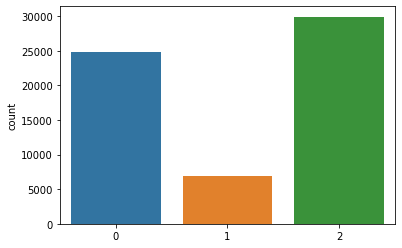

In [100]:
score = []
for value in data.Rating:
    if value < 3:
        score.append(0)
    if value == 3:
        score.append(1)
    if value > 3:
        score.append(2)
#plt.hist(score, bins=5)
sns.countplot(score)
plt.show()


In [101]:
# Removing hyperlink, hashtags, emojis, punctuation, stopwords. lower cases, tokenizing
text_loader = TextLoader(text_column="Review")

preprocessor = Preprocessor()
preprocessor.pipe(lower_text)
preprocessor.pipe(remove_mentions)
preprocessor.pipe(remove_hashtag)
preprocessor.pipe(remove_emoji)
preprocessor.pipe(remove_eol_characters)
preprocessor.pipe(remove_stopwords, args={'lang': 'en'})
preprocessor.pipe(remove_punct)
preprocessor.pipe(normalize_whitespace)

reviews = text_loader.read_text("reviews.csv", preprocessor=preprocessor)
print(reviews.head())


before:                                               Review
0  Great music service, the audio is high quality...
1  Please ignore previous negative rating. This a...
2  This pop-up "Get the best Spotify experience o...
3    Really buggy and terrible to use as of recently
4  Dear Spotify why do I get songs that I didn't ...


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:4389: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Review', 'object'))

  warnings.warn(meta_warning(meta))


after:                                               Review
0  great music service audio high quality app eas...
1  ignore previous negative rating app super grea...
2   pop spotify experience android 12 annoying s rid
3                            buggy terrible recently
4   dear spotify songs n t put playlist shuffle play
                                              Review
0  great music service audio high quality app eas...
1  ignore previous negative rating app super grea...
2   pop spotify experience android 12 annoying s rid
3                            buggy terrible recently
4   dear spotify songs n t put playlist shuffle play


### Model building

In [102]:
# add score to data 
reviews['Sentiment'] = score 
x, y = reviews['Review'], reviews['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

vect = CountVectorizer()
train_Review = vect.fit_transform(x_train)
test_Review = vect.transform(x_test)

print(train_Review.shape)
print(test_Review.shape)

(43115, 19492)
(18479, 19492)


In [103]:
# Model: I decided to test 2 models and chose the best case
#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(train_Review, y_train)
prediction = nb_model.predict(test_Review)

print("Accuracy: ", metrics.accuracy_score(y_test, prediction)*100, "%")

Accuracy:  76.59505384490502 %


### Word cloud
Let's make a word cloud from our data.

In [129]:
positive_review = reviews['Review'].loc[reviews["Sentiment"] == 2]
negative_review = reviews['Review'].loc[reviews["Sentiment"] == 0]
neutral_review = reviews['Review'].loc[reviews["Sentiment"] == 1]

def cloud(data, color):
    strings = ' '.join(data)
    myWordcloud = WordCloud(background_color=color,
                            width=2500,
                            height=2000,
                            stopwords=STOPWORDS).generate(strings)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(myWordcloud)
    plt.axis('off')
    plt.show() 

Positive reviews


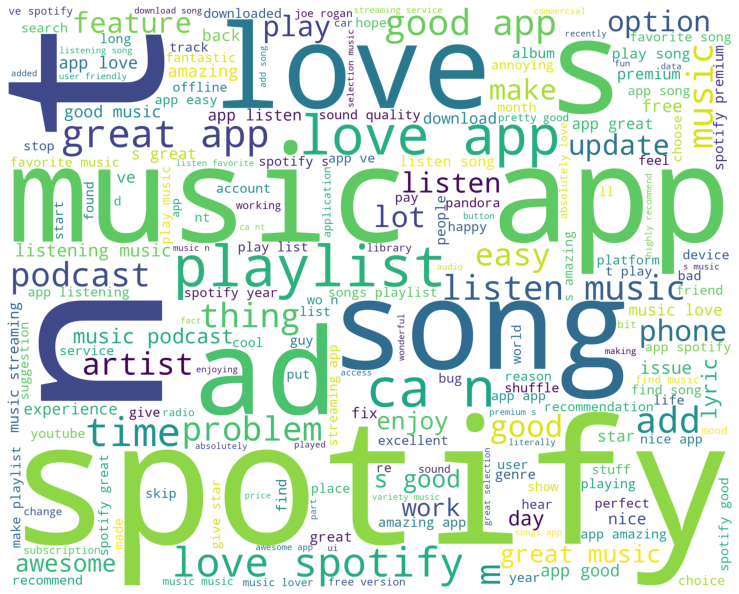

<Figure size 432x288 with 0 Axes>

In [128]:
print("Positive reviews")
cloud(positive_review,'white') 

Negative reviews 


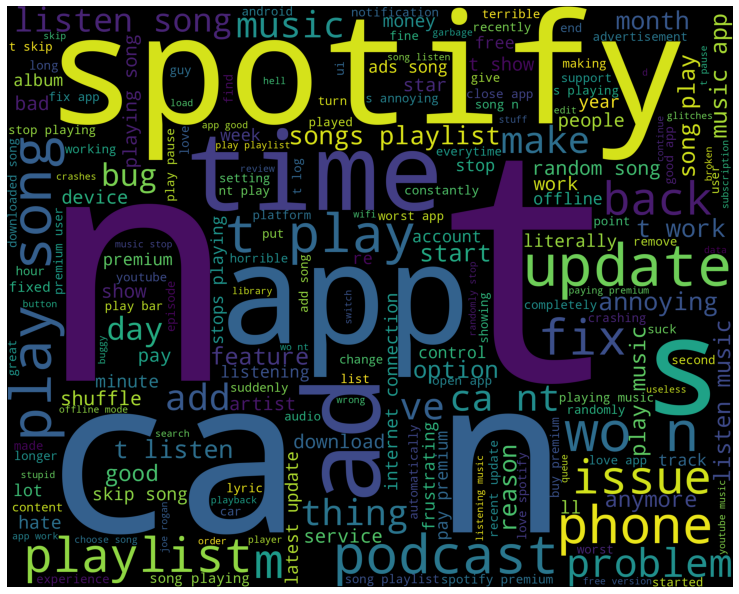

In [126]:
print("Negative reviews ")
cloud(negative_review, "black")

Neutral reviews 


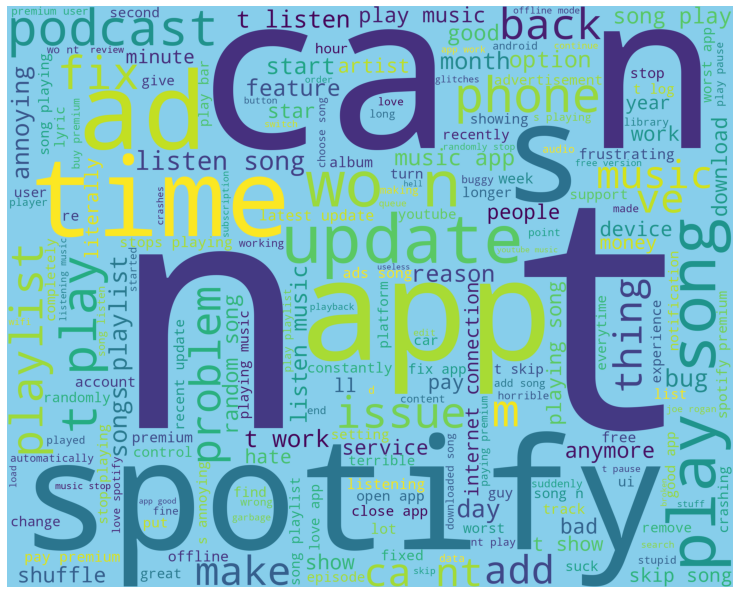

In [113]:
print("Neutral reviews ")
cloud(negative_review, "skyblue")